<a href="https://colab.research.google.com/github/tishakbhavsar/practising-pytorch/blob/main/04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Custom Datasets in Pytorch :D

We've used some datasets with PyTorch before. But how do you get your own data in PyTorch?

Domain libraries : Depending upon what you are working on, vision, text, audio, recommendation-> there torch libraries for each.

### 0.1 Importing PyTorch, Setting up device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

### 0.2 Working with Food-101 Data Set - Smaller Version


Our data is a subset of the larger data. Only three classes of food and only 10 % of the images (~75 training, ~25 testing). Starting small and humble :)

In [11]:
import requests
import zipfile
from pathlib import Path

# Set up path to a data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f'Image path exists. Skipping download!')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
  print("Downloading data...")
  f.write(request.content)

# Unzip the zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

# Remove zip file
import os
os.remove(data_path/"pizza_steak_sushi.zip")


Image path exists. Skipping download!
Unzipping pizza, steak and sushi data...


### Observing the data

In [14]:
import os
def walk_through_dr(dir_path):
  """ Walks through dir_path, returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} in '{dirpath}")

walk_through_dr(image_path)

There are 2 directories and 0 in 'data/pizza_steak_sushi
There are 3 directories and 0 in 'data/pizza_steak_sushi/train
There are 0 directories and 75 in 'data/pizza_steak_sushi/train/steak
There are 0 directories and 72 in 'data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 in 'data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 in 'data/pizza_steak_sushi/test
There are 0 directories and 19 in 'data/pizza_steak_sushi/test/steak
There are 0 directories and 31 in 'data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 in 'data/pizza_steak_sushi/test/pizza


#### Our labels are our folder names for example : pizza, steak and sushi are folder names

In [17]:
# Setup train and testing paths

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualising data

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python PIL
5. Show image metadata.

data/pizza_steak_sushi/train/sushi/821108.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/821108.jpg
Image class: sushi
Image height: 383
Image width: 512


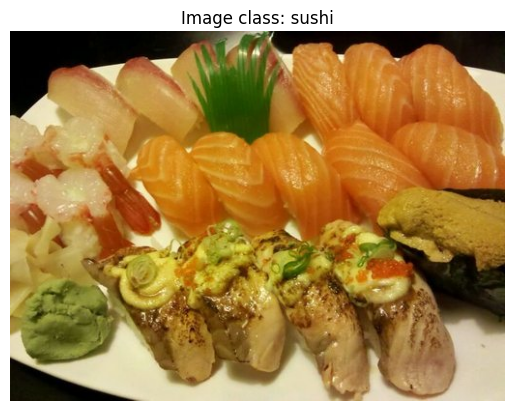

In [33]:
import random
from PIL import Image
import matplotlib.pyplot as plt
# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # we want all image paths (train-test/pizza-steak-sushi/image name)


# 2. Pick random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class (the image class is the name of the direc where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
plt.imshow(img)
plt.title(f'Image class: {image_class}')
plt.axis(False);

#### Visualizing with matplotlib!

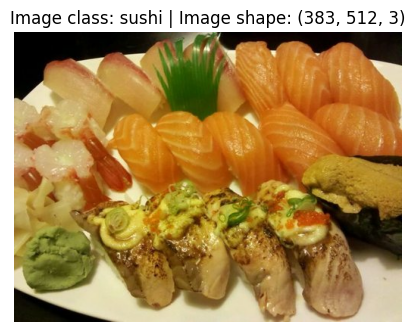

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape}')
plt.axis(False);

### 3. Transforming data

Before we can use our image data with PyTorch, we need to:

1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset`
3. Turn datasets into a `torch.utils.data.DataLoader`

In [36]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [38]:
# Write a transform for image

# to combine transforms we can use nn.Sequential or transfroms.Compose!
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Another transform to flip images - data augmentation - increasing diversity of the data
    transforms.RandomHorizontalFlip(p=0.5), # 50 % of the time, gets flipped
    transforms.ToTensor() # convert numpy array or PIL image to a tensor
])

In [45]:
transformed_image = data_transform(img) # did not work for data_transform(img_as_array)

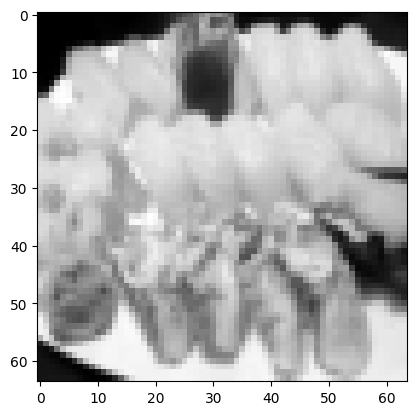

In [53]:
one_channel = transformed_image[0]
plt.imshow(one_channel, cmap="gray")

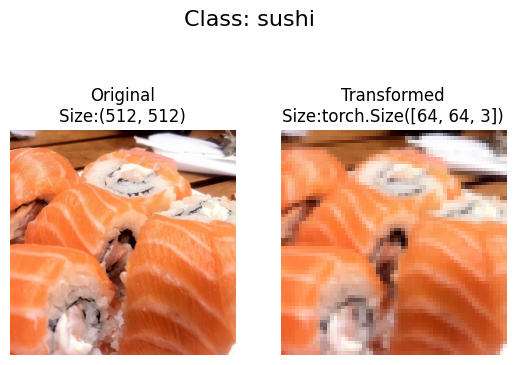

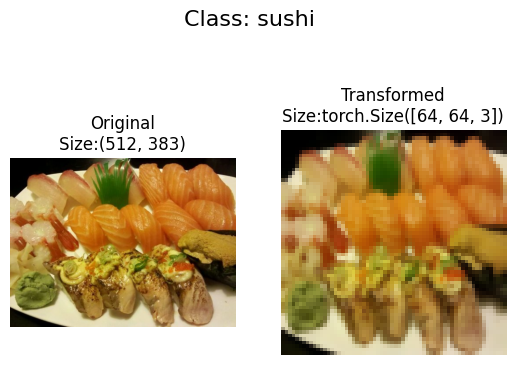

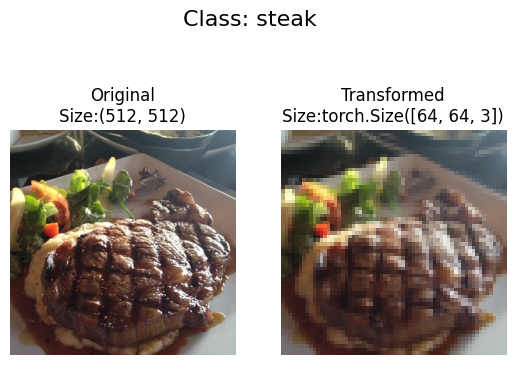

In [61]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """ Selects n random images from a path of images, transforms them
  with transform and plots them side by side with the original images.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # going from C H W to H W C because matplotlib supports H W C
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for maptlotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform = data_transform,
                        n = 3)

#### Doing it for all images

### Option 1: Loading data using ImageFolder

We can load image classification data using torchvision.datasets.ImageFolder


In [64]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform = data_transform,
                                  target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [67]:
# Get class names as a list
print(f"Class names: {train_data.classes}")
print(f"Class names as a dictionary: {train_data.class_to_idx}")

Class names: ['pizza', 'steak', 'sushi']
Class names as a dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [68]:
# Check the lengths of datasets
len(train_data), len(test_data)

(225, 75)

In [76]:
train_data[0][0], train_data[0][1] # image, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [87]:
print(f"Image shape: {train_data[0][0].shape}")
print(f"Label: {train_data[0][1]}")
class_names = train_data.classes

Image shape: torch.Size([3, 64, 64])
Label: 0


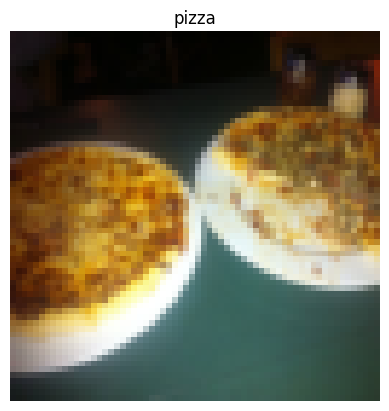

In [89]:
# Index on train_data Dataset to get a single image
image, label = train_data[0]
plt.imshow(image.permute(1,2,0)) # re arrange order of dimensions
plt.title(class_names[label])
plt.axis(False);

### Turn loaded images into DataLoaders

In [103]:
import os
os.cpu_count() # how many cpu cores -> shows google colab ones here -> 2

2

In [172]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1 # change to 32 later
#num_workers = 1 # how many CPU cores are working together to load your data?

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)


test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers = 1,
                              shuffle=False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [173]:
img, label = next(iter(train_dataloader))
image_shape, label_shape = img.shape, label.shape # - > added a batch dimension
print(f'Image shape: {image_shape}')
print(f'Label shape: {label_shape}')


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### Option 2: Without ImageFolder helper function! - Loading Image Data with a Custom `Dataset`

Write your own custom data loading function.

1. Want to be ablet o load images from file.
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset


PROS
- Can create a `Dataset` out of almost anything
- Not limited to PyTorch pre built `Dataset` functions

CONS
- Doesn't mean it will work...
- Using a custom dataset often results in us writing more code which could be prone to errors.


All custom datasets, often subclass this : `torch.utils.data.Dataset`



In [174]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [175]:
# INSTANCE of torchvision.datasets.ImageFolder() -> for replication of this functionality

train_data.classes, train_data.class_to_idx

# how to retrieve this information from our directory?

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5. 1 Creating helper function to get class names

1. Get class names using `os.scandir()`, traverse target dir, ideally should be formatted.

2. Raise an error, if class names aren't found! - hint that the directory structure should be better

3. turn it list and dict and return


In [176]:
target_dir = train_dir
# print(target_dir)

# class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
# print(f'Class names: {class_names_found}')

def find_class(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in a target directory."""
  class_names = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not class_names:
    raise FileNotFoundError(f'Cound not find classes in {directory}..please check file directory')
  class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
  return class_names, class_to_idx

In [177]:
class_names, class_to_idx = find_class(target_dir)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Creating Custom `Dataset`

1. subclass torch.utils.data.Dataset
2. Init out subclass with a target directory as well as transform.
3. create several attributes:
  paths - paths of images,
  transform
  classes - a list of target classes
  class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to load images - > open image
5. overwrite - > __len()__ function
5. overwrite the __getitem()__ method

In [178]:
class ImageFolderCustom(torch.utils.data.Dataset): # subclass !
  # Initialize !
  def __init__(self,
               targ_dir:str,
               transform=None):
    # Create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # get all image paths
    self.transform = transform # set transform
    # create classes and class_to_idx
    self.classes, self.class_to_idx = find_class(targ_dir)

  #  Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite len ( optional actually)
  def __len__(self):
    return len(self.paths)
  # Overwrite the get item method
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    """ Returns a target image and its class."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return transformed
    return img, class_idx # return untransformed



In [179]:
# Create a transform

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [180]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [181]:
len(train_data_custom),len(test_data_custom)

(225, 75)

In [182]:
class_names_custom, class_to_idx_custom = train_data_custom.classes, train_data_custom.class_to_idx
class_names_custom, class_to_idx_custom

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [183]:
# Check for equality
class_names == class_names_custom, class_to_idx == class_to_idx_custom

(True, True)

### 5.3 Visualize images from our custom dataset

1. Take in a `Dataset`, and other params - no of class names, how many images to visualize
2. MAX 10 images
3. random seed for reproducibility
4. get a random sample of indexes
5. set up a matplotlib plot
6. loop and plot !
7. make sure dimensions of our images matches (HWC)


For display purposes, n should not be larger than 10, setting to 10 and removing shape display!


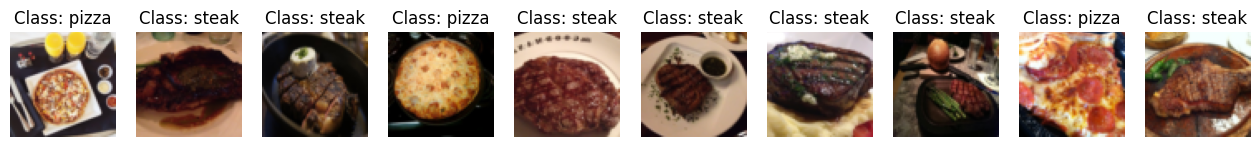

In [184]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed:int=None):
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n should not be larger than 10, setting to 10 and removing shape display!")
  if seed:
    random.seed(seed)

  # Get random samples
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  # Loop and plot
  for i, targ_sample in enumerate(random_sample_idx):
    img, label = dataset[targ_sample][0], dataset[targ_sample][1]
    permuted_img = img.permute(1,2,0)
    plt.subplot(1,n,i+1)
    plt.imshow(permuted_img)
    if classes:
      title = f"Class: {classes[label]}"
      if display_shape:
        title += f"\nshape: {permuted_img.shape}"
    else:
      title= f"Class: {label}"
      if display_shape:
        title += f"\nshape: {permuted_img.shape}"
    plt.title(title)
    plt.axis(False)

display_random_images(train_data_custom, train_data_custom.classes, 12, False, seed=42)

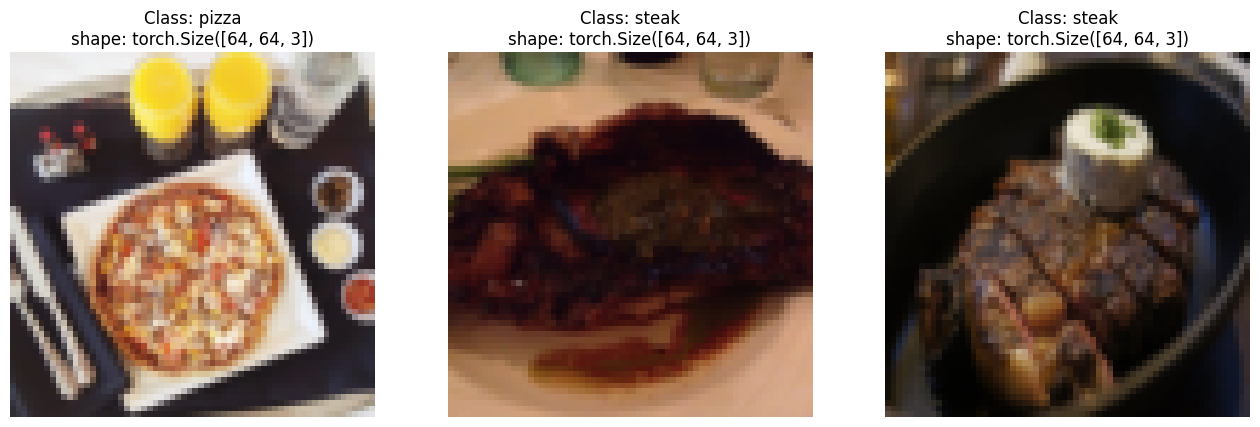

In [185]:
display_random_images(train_data_custom, train_data_custom.classes, 3, True, seed=42)

### 5.4 Turn custom dataset into dataloaders

In [186]:
import os
os.cpu_count()

2

In [187]:
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 0,
                                     shuffle=False)

In [188]:
len(train_dataloader_custom), len(test_dataloader_custom)

(225, 75)

## 6. Other forms of transform - Data Augmentation


Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean appying various transforms to training images. - > Increases generalizability to unseen data

Let us look at one particular type of data augmention, used to train PyTorch vision models to state of the art levels...

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [190]:
# Let look at trivialaugment

train_transform = transforms.Compose([
    transforms.Resize(size=(224,244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 31 max intensity -> rotate max for e.g
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,244)),
    transforms.ToTensor()
])

In [192]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/165639.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1413972.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2979061.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2881783.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/225990.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2606444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2017387.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3142045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg')]

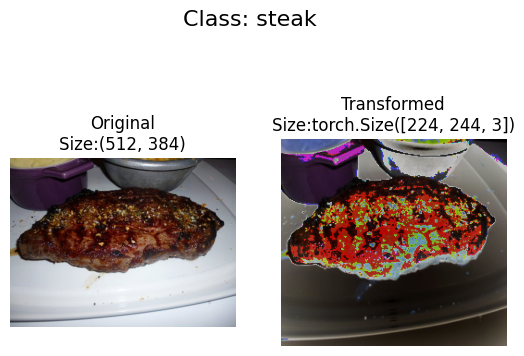

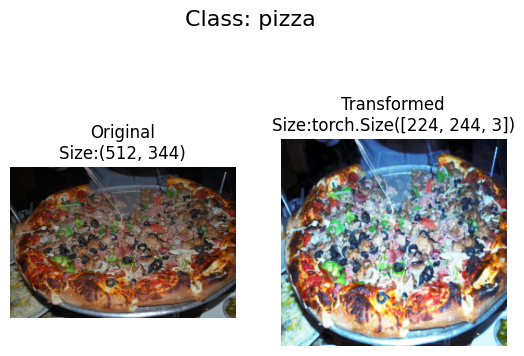

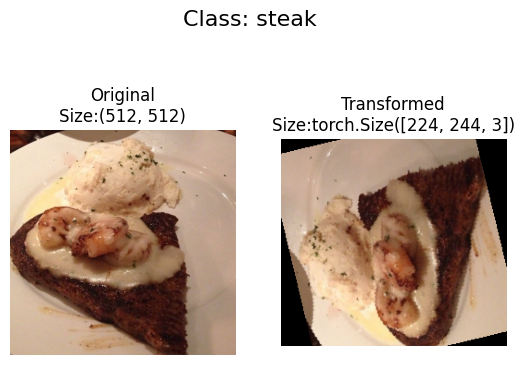

In [195]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

### 7. Building Model - FINALLY !!